## 1. Import Dependencies

In [1]:
import re
import os
import random
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

## 2. Utility Functions

In [ ]:
# The below functions add percentages on top of bars in bar charts

def with_hue(plot, feature, Number_of_categories, hue_categories):
    a = [p.get_height() for p in plot.patches]
    patch = [p for p in plot.patches]
    for i in range(Number_of_categories):
        total = feature.value_counts().values[i]
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 - 0.15
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() 
            ax.annotate(percentage, (x, y), size = 12)
    plt.show()

def without_hue(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()

## 3. Loading Data

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Case_Study_2/pre_processed2.csv', 
                 usecols = ['comment', 'parent_comment', 'label'])
df.head()

,label,comment,parent_comment
0,0,nc and nh,yeah i get that argument at this point i would...
1,0,you do know west teams play against west teams...,the blazers and mavericks the wests 5 and 6 se...
2,0,they were underdogs earlier today but since gr...,they are favored to win
3,0,this meme is not funny none of the new york ni...,deadass do not kill my buzz
4,0,i could use one of those tools,yep can confirm i saw the tool they use for th...


## 4. Train Test Split

In [3]:
X = df.drop(['label'], axis=1)
Y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, stratify=Y, random_state=42)
print('Train Data Shape: ', (X_train.shape, y_train.shape))
print('Test Data Shape: ', (X_test.shape, y_test.shape))

Train Data Shape:  ((807784, 2), (807784,))
Test Data Shape:  ((201947, 2), (201947,))


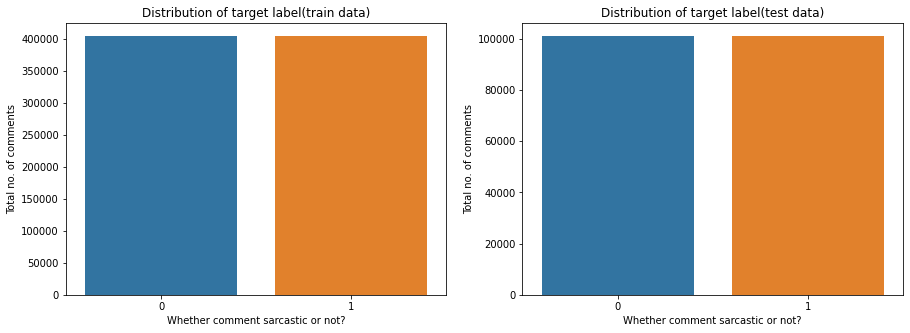

In [ ]:
f, axs = plt.subplots(1,2,figsize=(15,5))

# Distribution of target label train dataset
plt.subplot(1,2,1)
ax = sns.countplot(x=y_train)
plt.xlabel('Whether comment sarcastic or not?')
plt.ylabel('Total no. of comments')
plt.title('Distribution of target label(train data)')

# Distribution of target label test dataset
plt.subplot(1,2,2)
ax = sns.countplot(x=y_test)
plt.xlabel('Whether comment sarcastic or not?')
plt.ylabel('Total no. of comments')
plt.title('Distribution of target label(test data)')

plt.show()

## 5. Glove Embeddings

### 5.1. Vectorizing comment using glove embeddings



In [ ]:
# loading pre-trained glove embeddings
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model

In [ ]:
!unzip /content/drive/MyDrive/Case_Study_2/glove.42B.300d.zip

Archive:  /content/drive/MyDrive/Case_Study_2/glove.42B.300d.zip
  inflating: glove.42B.300d.txt      


In [ ]:
model = loadGloveModel('glove.42B.300d.txt')

Loading Glove Model
Done. 1917494  words loaded!


In [ ]:
# vectorizing comment in train data using glove embeddings
start = datetime.now()
glove_train = []
for comment in X_train['comment']:
    vector = np.zeros(300)
    for word in comment.split():
        if word in model.keys():
            vector += model[word]
    glove_train.append(vector)
glove_train = np.array(glove_train)
print("Time taken: ", datetime.now() - start)

Time taken:  0:00:20.078070


In [ ]:
# shape of train data embeddings
glove_train.shape

(807784, 300)

In [ ]:
# saving embeddings for train data column comment
with open('/content/drive/MyDrive/Case_Study_2/glove_comment_train.npy', 'wb') as f:
    np.save(f, glove_train)
print("Embeddings saved successfully!")

Embeddings saved successfully!


In [ ]:
# vectorizing comment in test data using glove embeddings
start = datetime.now()
glove_test = []
for comment in X_test['comment']:
    vector = np.zeros(300)
    for word in comment.split():
        if word in model.keys():
            vector += model[word]
    glove_test.append(vector)
glove_test = np.array(glove_test)
print("Time taken: ", datetime.now() - start)

Time taken:  0:00:04.670696


In [ ]:
# shape of test data embeddings
glove_test.shape

(201947, 300)

In [ ]:
# saving embeddings for test data column comment
with open('/content/drive/MyDrive/Case_Study_2/glove_comment_test.npy', 'wb') as f:
    np.save(f, glove_test)
print("Embeddings saved successfully!")

Embeddings saved successfully!






### 5.2 Loading saved glove embeddings

In [ ]:
# loading embeddings for train data column comment
with open('/content/drive/MyDrive/Case_Study_2/glove_comment_train.npy', 'rb') as f:
    glove_train = np.load(f)
print("Train Embeddings Shape: ", glove_train.shape)
f.close()

Train Embeddings Shape:  (807784, 300)


In [ ]:
# loading embeddings for test data column comment
with open('/content/drive/MyDrive/Case_Study_2/glove_comment_test.npy', 'rb') as f:
    glove_test = np.load(f)
print("Test Embeddings Shape: ", glove_test.shape)
f.close()

Test Embeddings Shape:  (201947, 300)


### 5.3 Logistic Regression on Glove Embeddings

In [ ]:
# preprocessing data to standardize data with mean 0
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
glove_train_scaled = scaler.fit_transform(glove_train)
glove_test_scaled = scaler.transform(glove_test)
print(glove_train_scaled.shape)
print(glove_test_scaled.shape)

(807784, 300)
(201947, 300)


In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=2000)
clf.fit(glove_train, y_train)

LogisticRegression(max_iter=2000)

In [ ]:
# Predictions on train and test data
y_train_pred = clf.predict(glove_train)
y_test_pred = clf.predict(glove_test)

In [ ]:
# Evaluating Logistic Regression model on train data
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.62      0.66      0.64    403621
           1       0.64      0.60      0.62    404163

    accuracy                           0.63    807784
   macro avg       0.63      0.63      0.63    807784
weighted avg       0.63      0.63      0.63    807784



In [ ]:
# Evaluating Logistic Regression model on test data
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.63      0.66      0.64    100906
           1       0.64      0.61      0.62    101041

    accuracy                           0.63    201947
   macro avg       0.63      0.63      0.63    201947
weighted avg       0.63      0.63      0.63    201947



### Observations:
1. Logistic Regresssion model with default parameters on glove embeddings gave an accuracy of 0.63 on test data set.

### 5.4 Naive Bayes on Glove Embeddings

In [ ]:
# preprocessing data to convert to range 0-1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
glove_train_scaled = scaler.fit_transform(glove_train)
glove_test_scaled = scaler.transform(glove_test)
print(glove_train_scaled.shape)
print(glove_test_scaled.shape)

(807784, 300)
(201947, 300)


In [ ]:
# MultinomialNB Model
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(glove_train_scaled, y_train)

MultinomialNB()

In [ ]:
# Predictions on train and test data
y_train_pred = clf.predict(glove_train_scaled)
y_test_pred = clf.predict(glove_test_scaled)

In [ ]:
# Evaluating Naive Bayes model on train data
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00    403621
           1       0.50      1.00      0.67    404163

    accuracy                           0.50    807784
   macro avg       0.75      0.50      0.33    807784
weighted avg       0.75      0.50      0.33    807784



In [ ]:
# Evaluating Naive Bayes model on test data
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00    100906
           1       0.50      1.00      0.67    101041

    accuracy                           0.50    201947
   macro avg       0.75      0.50      0.33    201947
weighted avg       0.75      0.50      0.33    201947



### Observations:
1. Naive Bayes model with default parameters on glove embeddings gave an accuracy of 0.50 on test data set.



```
# This is formatted as code
```

## 6. Fasttext Embeddings

In [ ]:
import fasttext
ft = fasttext.load_model('/content/drive/MyDrive/Case_Study_2/cc.en.300.bin')

### 6.1. Vectorizing comment using fasttext embeddings








In [ ]:
# vectorizing comment in train data using fast embeddings
start = datetime.now()
fasttext_train = []
for comment in X_train['comment'][600000:810000]:
    vector = np.zeros(300)
    for word in comment.split():
        vec = ft.get_word_vector(word)
        vector += vec
    fasttext_train.append(vector)
fasttext_train = np.array(fasttext_train)
print("Time taken: ", datetime.now() - start)

Time taken:  0:00:25.971493


In [ ]:
import pickle
with open('/content/drive/MyDrive/Case_Study_2/data_450000.pkl', 'rb') as f:
     group1 = pickle.load(f)
group1 = np.array(group1)
group1.shape

(450000, 300)

In [ ]:
with open('/content/drive/MyDrive/Case_Study_2/data_600000.pkl', 'rb') as f:
     group2 = pickle.load(f)
group2.shape

(150000, 300)

In [ ]:
with open('/content/drive/MyDrive/Case_Study_2/data_810000.pkl', 'rb') as f:
     group3 = pickle.load(f)
group3.shape

(207784, 300)

In [ ]:
# Combining all groups for final train text embeddings
fasttext_train = np.vstack((group1, group2, group3))
fasttext_train.shape

(807784, 300)

In [ ]:
# Saving final train embeddings
with open('/content/drive/MyDrive/Case_Study_2/fasttext_train.pkl', 'wb') as f:
     pickle.dump(fasttext_train, f)

In [ ]:
# vectorizing comment in test data using fast embeddings
start = datetime.now()
fasttext_test = []
for comment in X_test['comment']:
    vector = np.zeros(300)
    for word in comment.split():
        vec = ft.get_word_vector(word)
        vector += vec
    fasttext_test.append(vector)
fasttext_test = np.array(fasttext_test)
print("Time taken: ", datetime.now() - start)

Time taken:  0:00:25.088222


In [ ]:
fasttext_test.shape

(201947, 300)

In [ ]:
# Saving final test embeddings
import pickle
with open('/content/drive/MyDrive/Case_Study_2/fasttext_test.pkl', 'wb') as f:
     pickle.dump(fasttext_test, f)

### 6.2. Loading Saved fasttext embeddings


In [ ]:
with open('/content/drive/MyDrive/Case_Study_2/fasttext_train.pkl', 'rb') as f:
     fasttext_train = pickle.load(f)
fasttext_train.shape

(807784, 300)

In [ ]:
with open('/content/drive/MyDrive/Case_Study_2/fasttext_test.pkl', 'rb') as f:
     fasttext_test = pickle.load(f)
fasttext_test.shape

(201947, 300)

### 6.3 Naive Bayes on fasttext embeddings




In [ ]:
# preprocessing data to convert to range 0-1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
fasttext_train_scaled = scaler.fit_transform(fasttext_train)
fasttext_test_scaled = scaler.transform(fasttext_test)
print(fasttext_train_scaled.shape)
print(fasttext_test_scaled.shape)

(807784, 300)
(201947, 300)


In [ ]:
# MultinomialNB Model
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(fasttext_train_scaled, y_train)

MultinomialNB()

In [ ]:
# Predictions on train and test data
y_train_pred = clf.predict(fasttext_train_scaled)
y_test_pred = clf.predict(fasttext_test_scaled)

In [ ]:
# Evaluating Naive Bayes model on train data
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.81      0.00      0.00    403621
           1       0.50      1.00      0.67    404163

    accuracy                           0.50    807784
   macro avg       0.65      0.50      0.33    807784
weighted avg       0.65      0.50      0.33    807784



In [ ]:
# Evaluating Naive Bayes model on test data
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.00      0.00    100906
           1       0.50      1.00      0.67    101041

    accuracy                           0.50    201947
   macro avg       0.68      0.50      0.33    201947
weighted avg       0.68      0.50      0.33    201947



### 6.3 Logistic Regression on fasttext embeddings


In [ ]:
# preprocessing data to convert to range 0-1
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
fasttext_train_scaled = scaler.fit_transform(fasttext_train)
fasttext_test_scaled = scaler.transform(fasttext_test)
print(fasttext_train_scaled.shape)
print(fasttext_test_scaled.shape)

(807784, 300)
(201947, 300)


In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=2000)
clf.fit(fasttext_train, y_train)

LogisticRegression(max_iter=2000)

In [ ]:
# Predictions on train and test data
y_train_pred = clf.predict(fasttext_train)
y_test_pred = clf.predict(fasttext_test)

In [ ]:
# Evaluating Naive Bayes model on train data
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.63      0.66      0.64    403621
           1       0.64      0.61      0.62    404163

    accuracy                           0.63    807784
   macro avg       0.63      0.63      0.63    807784
weighted avg       0.63      0.63      0.63    807784



In [ ]:
# Evaluating Naive Bayes model on test data
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.63      0.66      0.64    100906
           1       0.64      0.61      0.63    101041

    accuracy                           0.64    201947
   macro avg       0.64      0.64      0.63    201947
weighted avg       0.64      0.64      0.63    201947



### Observations
1. Logistic Regression baseline model gave better results with both fasttext and glove embeddings.
2. Both glove embeddings and fasttext embeddings gave similar results, with Logistic Regression model giving slightly better accuracy with Fasttext embeddings.

## Conclusion

1. Achieved a maximum validation accuracy of 64% with Logistic Regression(default parameters).
2. Both glove embeddings and fasttext embeddings gave similar results, with fasttext embeddings giving a slightly better accuracy. However, fasttext embeddings required much higher processing power.


In [3]:
#@title
myTable = PrettyTable(["Baseline Model", "Embedding", "Train Accuracy", "Val Accuracy", "Train F1 score", "Val F1 Score"])
myTable.add_row(["Logistic Regression", "Fasttext", 0.63, 0.64, 0.63, 0.63])
myTable.add_row(["Logistic Regression", "Glove", 0.63, 0.63, 0.63, 0.63])
myTable.add_row(["Naive Bayes", "Fastext", 0.50, 0.50, 0.33, 0.33])
myTable.add_row(["Naive Bayes", "Glove", 0.50, 0.50, 0.33, 0.33])
print(myTable)

+---------------------+-----------+----------------+--------------+----------------+--------------+
|    Baseline Model   | Embedding | Train Accuracy | Val Accuracy | Train F1 score | Val F1 Score |
+---------------------+-----------+----------------+--------------+----------------+--------------+
| Logistic Regression |  Fasttext |      0.63      |     0.64     |      0.63      |     0.63     |
| Logistic Regression |   Glove   |      0.63      |     0.63     |      0.63      |     0.63     |
|     Naive Bayes     |  Fastext  |      0.5       |     0.5      |      0.33      |     0.33     |
|     Naive Bayes     |   Glove   |      0.5       |     0.5      |      0.33      |     0.33     |
+---------------------+-----------+----------------+--------------+----------------+--------------+
